In [12]:
# utils
def parse_line(line,option='default'):
    if option == 'set':
        return list(set(int(num.strip()) for num in line.strip("{}\n").split(",")))
    return list(int(num.strip()) for num in line.strip("{}\n").split(","))

def converse(string,dictionary):
    res = 0
    for letter in string:
        res = res+(dictionary[letter])
        
    return res

def reverseDict(original_dict):
    reversed_dict = {}
    for key, value in original_dict.items():
        reversed_dict[value] = int(key)
    return reversed_dict

In [10]:
import re
import copy


alphabet = [
                'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
            ]

class LevelTracker:
    def __init__(self,depth, content):
        """Track the occurence of every number from a level
        Attributes:
            depth::int     the depth of the numerical level we are tracking
            content::int   the list of numbers in this level
    
        """
        self.depth = depth
        self.content = content
        
        
    def track(self):
        """Start tracking the occurence of each number from this level and store these data inside a new attribute (self.tracker)
        """
        self.tracker = {
            x: self.content.count(x) for x in set(self.content)
        }

class NumericalLevels:
    def __init__(self,filename, generators):
        """Data structure that stores the numerical values of each level from the text file
        
        Attributes:
            filename::str     The name of the .txt file that store all the numerical levels
            generators::[int]   The list of Apery numbers of a given numerical semigroup
        
        """
        self.filename = filename
        self.generators = generators
        
        self.trackers = []
     
    def populate(self):
        """Read in the data and store them in two formats as two new attributes of the object.
        
        Returns:
            self.original_levels::[int]     An array storing the numerical values in each level allowing duplicacy
            self.clumped_levels::[int]      An array storing the numerical values in each level without any duplicated number
        """
        with open(self.filename, "r") as file:
            lines = file.readlines()
        
        self.original_levels = [sorted(parse_line(line, 'default')) for line in lines]
        self.clumped_levels = [sorted(list(set(level))) for level in self.original_levels]
        
        self.clumped_levels = [[0]]+self.clumped_levels
        
        self.original_levels = [[0]] + self.original_levels
     
    def tracking(self):
        """Assign each level a dictionary that store the number of occurences for each element in said level"""
        for index in range( len(self.original_levels) ):
            level_tracker = LevelTracker(
                depth = index,
                content = self.original_levels[index] 
            )
            level_tracker.track()
            
            self.trackers.append(
                level_tracker
            )
        
class NumericalWord:
    def __init__(self, numerical_value):
        """Data structure that stores a numerical value and all of its valid word formations
        
        Attributes:
            numerical_value::int     A type-int object that stores the numerical value of an element in a numerical level
            words::[str]             An array that stores all possible word formations of a number
        """
        self.numerical_value = numerical_value
        
        if self.numerical_value == 0:
            self.words = ['']
        else:
            self.words = []
        
    def __str__(self):
        return f"Numerical value: {self.numerical_value}\nAssociated words: {self.words}\n"
        
    def addWord(self,string):
        """Add a possible word formation to the numerical value"""
        self.words.append(string)
    
    def modify(self, letter):
        """Find a match from the next level and then add the corresponding letter to the end of all word formations we have so far for this numerical value"""
        return [
            wrd+letter for wrd in self.words
        ]
        
    def _size(self):
        return len(self.words)

class WordGenerator:
    def __init__(self, regex, generators):
        """The highest level data structure. Its job is to store all the information about numerical values from all levels of a given numerical semigroup
        
        Attributes:
            regex::str                  A regular expression that represents the most general form of the language
            generators::[int]           The list of Apery numbers of a given numerical semigroup
            dictionary::dict            A dictionary to converse an Apery number to its corresponding letter in the alphabet
            reverse_dictionary::dict    The key-value pair inversion of self.dictionary 
        """
        self.regex = regex
        self.generators = generators
        self.startwith = ''
        

        self.dictionary = {}
        self.reverse_dictionary = {}

        self.words_list= []
        
    def __str__(self):
        return f"Generators: {self.generators}\nConstraint: {self.regex}"
    
    def satisfy(self, string):
        """Prototype for the set of rules that might be implemented in a single class in the future. For now, we're only concerned with the general form of the language
        
        Params:
            string::str     A possible word formation that needed to be checked with self.regex and self.startwith
            
        Returns:
            True::Bool       If the word formation fits in with self.regex
            False::Bool      If otherwise
        """
        if self.startwith != '':
            return re.fullmatch(self.regex, string) and re.startwith(self.startwith, string) 
        if self.regex != '':
            return re.fullmatch(self.regex, string)
        return True
    
    def execute(self, filename):
        """Build all the word formations of each numerical value in every level
        
        Returns:
            self.words_list::[[NumericalWord]]        A new attribute of WordGenerator object that stores all possible words formation 
                                                      from all levels as a 2D array of type 
            
        """
        self.numerical_levels = NumericalLevels(
            filename = filename,
            generators = self.generators,
        )
        
        self.numerical_levels.populate()
        self.numerical_levels.tracking()
        
            
        levels = self.numerical_levels.clumped_levels
        
        # first letters should be assigned to numbers in the first level
        # any additional generators will be kept track of by the mismatch variable
        counter = 0
        mismatch = len(
            set(self.generators).symmetric_difference(set(levels[1]))
        )
        
        
        # create dictionary and its reverse variant
        for index in range(len(self.generators)):
            if self.generators[index] in levels[1]:
                self.dictionary[str(self.generators[index])] = alphabet[counter]
                counter += 1
            else:
                self.dictionary[str(self.generators[index])] = alphabet[len(self.generators)+mismatch-2]
                mismatch += 1
        
        self.reverse_dictionary = reverseDict(self.dictionary)
        # first level
        self.words_list.append([
            NumericalWord(0)
        ])
        
        # main loop
        for depth in range(1, len(levels)):
            # curren level's placeholder
            new_words = []
            
            for current_element_index in range(len(levels[depth])):
                flag = False
                tmp_word = NumericalWord(
                    levels[depth][current_element_index]
                )
                for previous_element_index in range(len(levels[depth-1])):
                    diff = levels[depth][current_element_index] - levels[depth-1][previous_element_index]
                    if diff in self.generators:
                        flag = True
                        mod = self.words_list[depth-1][previous_element_index].modify(
                            self.dictionary[str(diff)]
                        )
                        for wrd in mod:
                            if self.satisfy(wrd):
                                tmp_word.addWord(wrd)
                
                if flag == False:
                    print("extra word: {}!\n".format(tmp_word.numerical_value))
                    tmp_word.addWord('')
                
                tmp_word.words =sorted(tmp_word.words)
                new_words.append(tmp_word)
                    
            self.words_list.append(new_words)
            
    def prettify(self, wordsList):
        """Print out the content of a words list
        
        Params:
            wordsList::[[NumericalWord]]     The 2D lists of word that need to be printed out
        """
        for level in wordsList:
            for word in level:
                print(word)
    

    def nitpick(self, wordsList, mode=1, freq = None, excess = None):
        """Print out any number that has the same/different number of words as the number of times it occurs
        
        Params:
            wordsList::[[NumericalWord]]     The 2D lists of word that need to be checked
            mode::int                        The functioning mode
                                                mode = 0 -> print out words that have different number of occurences
                                                mode = 1 -> print out words that have the same number of occurences
                                                mode = 2 -> print out words that whose occurences exceed a specific amoumt
                                                mode = 3 -> print out words that are supposed to occur a specific amount of time
                                                
            freq::int                        Reserved specifically for mode 3
            excess::int                      Reserved specifically for mode 2
        
        Returns:
            excedance::[int]                 A flatten-out 1D array that stores the the amount of excedance each word has, reserved
                                             specifically for mode 0.
        """
        xor = False if mode == 1 else True
        excedance = []
        for idx in range( len(wordsList) ):
            for value in wordsList[idx]:
                if mode == 3:
                    if self.numerical_levels.trackers[idx].tracker[value.numerical_value] == freq:
                        print(value)
                elif mode == 2:
                    if value._size() - self.numerical_levels.trackers[idx].tracker[value.numerical_value] == excess:
                        print(value)
                else:
                    if (value._size() == self.numerical_levels.trackers[idx].tracker[value.numerical_value]) != xor:
                        print(value)
                        if mode == 0:
                            print("Exceed by {} words.\n".format(
                                value._size() - self.numerical_levels.trackers[idx].tracker[value.numerical_value]
                            ))
                            excedance.append(
                                value._size() - self.numerical_levels.trackers[idx].tracker[value.numerical_value]
                            )
        return excedance
    # see the cascading effect of excluding a list of specific words of some numerical values from a level
    def exclude(self, wordsList, excluded_words=[''], mode = 0,verbose = 'quiet',freq=0):
        """See the cascading effect of excluding a list of specific words of some numerical values from a level
        
        Params:
            wordsList::[[NumericalWord]]       The 2D lists of word that need to be checked
            excluded_words[str]                The array of words that need to be excluded
            mode::int                          Functioning mode (default 0)
                                                   mode = 0 -> excluding words that start with any element in excluded_word
                                                   mode = 1 -> excluding words that have a portion matched up with any element in excluded_word
           verbose::str                        Set to something else if you want to print out the new list after excluding unwanted word
           
        Returns:
            modified_words_list::[[NumericalWord]]     The new word list from wordsList after we exclude unwanted words.
        """
        modified_words_list = copy.deepcopy(wordsList)
        
        pattern = r'|'.join(map(re.escape, excluded_words)) if mode == 1 else r"\b(?:{})".format("|".join(map(re.escape, excluded_words)))
        
        word = sorted(excluded_words, key=len)[0]
        # main loop
        for level_index in range( len(word), len(wordsList) ):
            for word_index in range( len(wordsList[level_index]) ):
                for idx in range( len(wordsList[level_index][word_index].words) ):
                    flag = re.match(pattern,wordsList[level_index][word_index].words[idx] ) if mode == 0 else re.findall(pattern, wordsList[level_index][word_index].words[idx])
                    if flag and self.numerical_levels.trackers[level_index].tracker[wordsList[level_index][word_index].numerical_value] >= freq:
                            modified_words_list[level_index][word_index].words.remove(
                                wordsList[level_index][word_index].words[idx]
                            )
                            
        
        if verbose == 'verbose':
            self.prettify(modified_words_list)
        return modified_words_list
    
    # export to .csv format
    def to_csv(self, target_list, filename):
        """Export a given words list to a separate .csv file
        
        Params:
            target_list::[[NumericalWord]]      The words list that we want to export
            filename::str                       The name for the .csv file
        
        """
        filepath = filename
        
        with open(filepath, mode='w', newline='') as file:
            import csv
            
            fieldnames = ["Level", "Numerical Value", "Associated Words"]
            
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            
            writer.writeheader
            
            for level in range(len(target_list)):
                for word in range(len(target_list[level])):
                    writer.writerow({
                        "Level": level,
                        "Numerical Value": target_list[level][word].numerical_value,
                        "Associated Words": set(target_list[level][word].words)
                    })   
        

In [25]:
help(NumericalWord)

Help on class NumericalWord in module __main__:

class NumericalWord(builtins.object)
 |  NumericalWord(numerical_value)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, numerical_value)
 |      Data structure that stores a numerical value and all of its valid word formations
 |      
 |      Attributes:
 |          numerical_value   A type-int object that stores the numerical value of an element in a numerical level
 |          words             An array that stores all possible word formations of a number
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  addWord(self, string)
 |      Add a possible word formation to the numerical value
 |  
 |  modify(self, letter)
 |      Find a match from the next level and then add the corresponding letter to the end of all word formations we have so far for this numerical value
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for i

In [13]:
gen = WordGenerator(
    regex = r'(a(b|c|d|e)*)|((b|c|d|e)*)',
    generators = [5, 91, 162, 253, 304],
)
gen.execute("layers.txt")
gen.to_csv(gen.words_list, "test1.csv")

In [14]:
excedance = gen.nitpick(gen.words_list, mode = 0, freq = 1)

Numerical value: 253
Associated words: ['bc', 'cb']

Exceed by 1 words.

Numerical value: 258
Associated words: ['abc', 'acb']

Exceed by 1 words.

Numerical value: 344
Associated words: ['bbc', 'bcb', 'cbb']

Exceed by 2 words.

Numerical value: 415
Associated words: ['bcc', 'cbc', 'ccb']

Exceed by 2 words.

Numerical value: 557
Associated words: ['bcd', 'bdc', 'cbd', 'cdb', 'dbc', 'dcb']

Exceed by 2 words.

Numerical value: 349
Associated words: ['abbc', 'abcb', 'acbb']

Exceed by 2 words.

Numerical value: 420
Associated words: ['abcc', 'acbc', 'accb']

Exceed by 2 words.

Numerical value: 435
Associated words: ['bbbc', 'bbcb', 'bcbb', 'cbbb']

Exceed by 3 words.

Numerical value: 506
Associated words: ['bbcc', 'bcbc', 'bccb', 'cbbc', 'cbcb', 'ccbb']

Exceed by 5 words.

Numerical value: 562
Associated words: ['abcd', 'abdc', 'acbd', 'acdb', 'adbc', 'adcb']

Exceed by 2 words.

Numerical value: 577
Associated words: ['bbbd', 'bbdb', 'bccc', 'bdbb', 'cbcc', 'ccbc', 'cccb', 'dbbb']


In [15]:
first_iteration  = gen.exclude(
    gen.words_list,
    excluded_words = ['cb'],
    mode = 1
)
excedance = gen.nitpick(first_iteration, mode = 0)

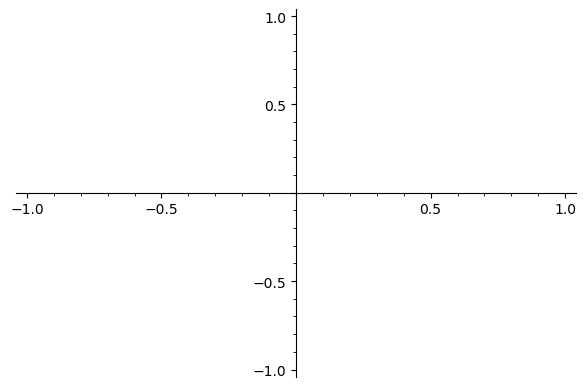

In [16]:
# Plot the array
p = list_plot(excedance, color='red', marker='o')

# Show the plot
show(p)

In [3]:
second_gen = WordGenerator(
    regex = r'(a(b|c|d|e)*)|((b|c|d|e)*)',
    generators = [5, 21, 42, 28, 14],
    startwith=''
)
second_gen.execute("simple.txt")
second_gen.to_csv(second_gen.words_list, "test2.csv")

In [4]:
second_excedance = second_gen.nitpick(
    second_gen.words_list,
    mode = 0
)

Numerical value: 49
Associated words: ['bcc', 'cbc']

Exceed by 1 words.

Numerical value: 56
Associated words: ['bbc', 'bcb', 'cbb']

Exceed by 1 words.

Numerical value: 54
Associated words: ['abcc', 'acbc']

Exceed by 1 words.

Numerical value: 61
Associated words: ['abbc', 'abcb', 'acbb']

Exceed by 1 words.

Numerical value: 70
Associated words: ['bbcc', 'bcbc', 'bccb', 'cbbc', 'cbcb']

Exceed by 3 words.

Numerical value: 77
Associated words: ['bbbc', 'bbcb', 'bcbb', 'cbbb']

Exceed by 2 words.

Numerical value: 75
Associated words: ['abbcc', 'abcbc', 'abccb', 'acbbc', 'acbcb']

Exceed by 3 words.

Numerical value: 82
Associated words: ['abbbc', 'abbcb', 'abcbb', 'acbbb']

Exceed by 2 words.

Numerical value: 84
Associated words: ['bbccc', 'bcbcc', 'bccbc', 'cbbcc', 'cbcbc']

Exceed by 4 words.

Numerical value: 91
Associated words: ['bbbcc', 'bbcbc', 'bbccb', 'bcbbc', 'bcbcb', 'bccbb', 'cbbbc', 'cbbcb', 'cbcbb']

Exceed by 7 words.

Numerical value: 98
Associated words: ['bbbbc'

In [5]:
second_gen.nitpick(second_gen.words_list, mode = 3, freq = 2)

Numerical value: 35
Associated words: ['bc', 'cb']

Numerical value: 40
Associated words: ['abc', 'acb']

Numerical value: 56
Associated words: ['bbc', 'bcb', 'cbb']

Numerical value: 61
Associated words: ['abbc', 'abcb', 'acbb']

Numerical value: 70
Associated words: ['bbcc', 'bcbc', 'bccb', 'cbbc', 'cbcb']

Numerical value: 77
Associated words: ['bbbc', 'bbcb', 'bcbb', 'cbbb']

Numerical value: 75
Associated words: ['abbcc', 'abcbc', 'abccb', 'acbbc', 'acbcb']

Numerical value: 82
Associated words: ['abbbc', 'abbcb', 'abcbb', 'acbbb']

Numerical value: 91
Associated words: ['bbbcc', 'bbcbc', 'bbccb', 'bcbbc', 'bcbcb', 'bccbb', 'cbbbc', 'cbbcb', 'cbcbb']

Numerical value: 98
Associated words: ['bbbbc', 'bbbcb', 'bbcbb', 'bcbbb', 'cbbbb']

Numerical value: 96
Associated words: ['abbbcc', 'abbcbc', 'abbccb', 'abcbbc', 'abcbcb', 'abccbb', 'acbbbc', 'acbbcb', 'acbcbb']

Numerical value: 103
Associated words: ['abbbbc', 'abbbcb', 'abbcbb', 'abcbbb', 'acbbbb']

Numerical value: 105
Associat

[]

In [19]:
second_gen.nitpick(second_gen.words_list, mode = 3, freq = 2)

Numerical value: 35
Associated words: ['bc', 'cb']

Numerical value: 40
Associated words: ['abc', 'acb']

Numerical value: 56
Associated words: ['bbc', 'bcb', 'cbb']

Numerical value: 61
Associated words: ['abbc', 'abcb', 'acbb']

Numerical value: 70
Associated words: ['bbcc', 'bcbc', 'bccb', 'cbbc', 'cbcb']

Numerical value: 77
Associated words: ['bbbc', 'bbcb', 'bcbb', 'cbbb']

Numerical value: 75
Associated words: ['abbcc', 'abcbc', 'abccb', 'acbbc', 'acbcb']

Numerical value: 82
Associated words: ['abbbc', 'abbcb', 'abcbb', 'acbbb']

Numerical value: 91
Associated words: ['bbbcc', 'bbcbc', 'bbccb', 'bcbbc', 'bcbcb', 'bccbb', 'cbbbc', 'cbbcb', 'cbcbb']

Numerical value: 98
Associated words: ['bbbbc', 'bbbcb', 'bbcbb', 'bcbbb', 'cbbbb']

Numerical value: 96
Associated words: ['abbbcc', 'abbcbc', 'abbccb', 'abcbbc', 'abcbcb', 'abccbb', 'acbbbc', 'acbbcb', 'acbcbb']

Numerical value: 103
Associated words: ['abbbbc', 'abbbcb', 'abbcbb', 'abcbbb', 'acbbbb']

Numerical value: 105
Associat

[]

In [19]:
first_iteration = second_gen.exclude(
    second_gen.words_list,
    excluded_words = ['cbb', 'ccb', 'cbcb', ], # remove cb leads to a weird phenom
    mode = 1
)
# 'cbb', 'ccb', 'cbcb'
second_gen.to_csv(first_iteration, 'sus.csv')

In [18]:
second_gen.nitpick(first_iteration, mode =1 , freq = 1)

Numerical value: 0
Associated words: ['']

Numerical value: 5
Associated words: ['a']

Numerical value: 14
Associated words: ['c']

Numerical value: 21
Associated words: ['b']

Numerical value: 19
Associated words: ['ac']

Numerical value: 26
Associated words: ['ab']

Numerical value: 35
Associated words: ['bc', 'cb']

Numerical value: 42
Associated words: ['bb']

Numerical value: 40
Associated words: ['abc', 'acb']

Numerical value: 47
Associated words: ['abb']

Numerical value: 56
Associated words: ['bbc', 'bcb']

Numerical value: 63
Associated words: ['bbb']

Numerical value: 61
Associated words: ['abbc', 'abcb']

Numerical value: 68
Associated words: ['abbb']

Numerical value: 70
Associated words: ['bbcc', 'bcbc']

Numerical value: 77
Associated words: ['bbbc', 'bbcb']

Numerical value: 84
Associated words: ['bbbb']

Numerical value: 75
Associated words: ['abbcc', 'abcbc']

Numerical value: 82
Associated words: ['abbbc', 'abbcb']

Numerical value: 89
Associated words: ['abbbb']

Nu

[]

In [15]:
second_excedance = second_gen.nitpick(first_iteration, mode =0 , freq = 1)

Numerical value: 49
Associated words: ['bcc', 'cbc']

Exceed by 1 words.

Numerical value: 54
Associated words: ['abcc', 'acbc']

Exceed by 1 words.

Numerical value: 105
Associated words: ['bbbccc']

Exceed by -1 words.

Numerical value: 110
Associated words: ['abbbccc']

Exceed by -1 words.

Numerical value: 126
Associated words: ['bbbbccc']

Exceed by -1 words.

Numerical value: 131
Associated words: ['abbbbccc']

Exceed by -1 words.

Numerical value: 140
Associated words: ['bbbbcccc']

Exceed by -1 words.

Numerical value: 147
Associated words: ['bbbbbccc']

Exceed by -1 words.

Numerical value: 145
Associated words: ['abbbbcccc']

Exceed by -1 words.

Numerical value: 152
Associated words: ['abbbbbccc']

Exceed by -1 words.

Numerical value: 161
Associated words: ['bbbbbcccc']

Exceed by -1 words.

Numerical value: 168
Associated words: ['bbbbbbccc']

Exceed by -1 words.

Numerical value: 166
Associated words: ['abbbbbcccc']

Exceed by -1 words.

Numerical value: 173
Associated wo

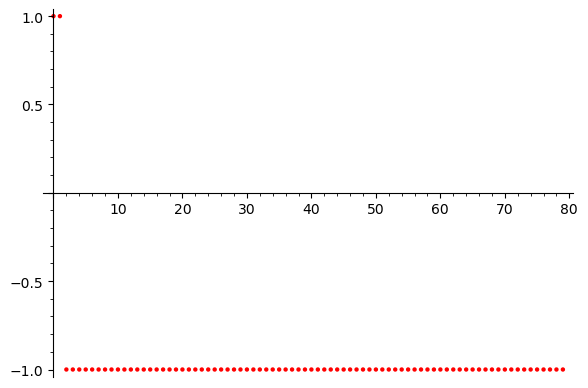

In [16]:
# Plot the array
p = list_plot(second_excedance, color='red', marker='o')

# Show the plot
show(p)